Total frames: 322
Usable right heel frames: 322
Y-change threshold (filtering top 25%): 0.0326

DEBUG: All potential minima:
Frame 4: Y=0.752, Y-change=0.0022, Type=HEEL
Frame 39: Y=0.826, Y-change=0.0140, Type=HEEL
Frame 46: Y=0.824, Y-change=0.0109, Type=HEEL
Frame 80: Y=0.747, Y-change=0.0351, Type=SWING
Frame 122: Y=0.827, Y-change=0.0173, Type=HEEL
Frame 157: Y=0.753, Y-change=0.0337, Type=SWING
Frame 186: Y=0.859, Y-change=0.0006, Type=HEEL
Frame 200: Y=0.842, Y-change=0.0137, Type=HEEL
Frame 234: Y=0.769, Y-change=0.0315, Type=HEEL
Frame 275: Y=0.870, Y-change=0.0113, Type=HEEL
Frame 307: Y=0.774, Y-change=0.0424, Type=SWING

DEBUG: Processing heel strike candidate at frame 4, Y=0.752
  Found 0 swing peaks within 60 frames before
  0 swing peaks meet Y-position criteria (< 0.702)
  ❌ REJECTED: No preceding swing phase found

DEBUG: Processing heel strike candidate at frame 39, Y=0.826
  Found 0 swing peaks within 60 frames before
  0 swing peaks meet Y-position criteria (< 0.776

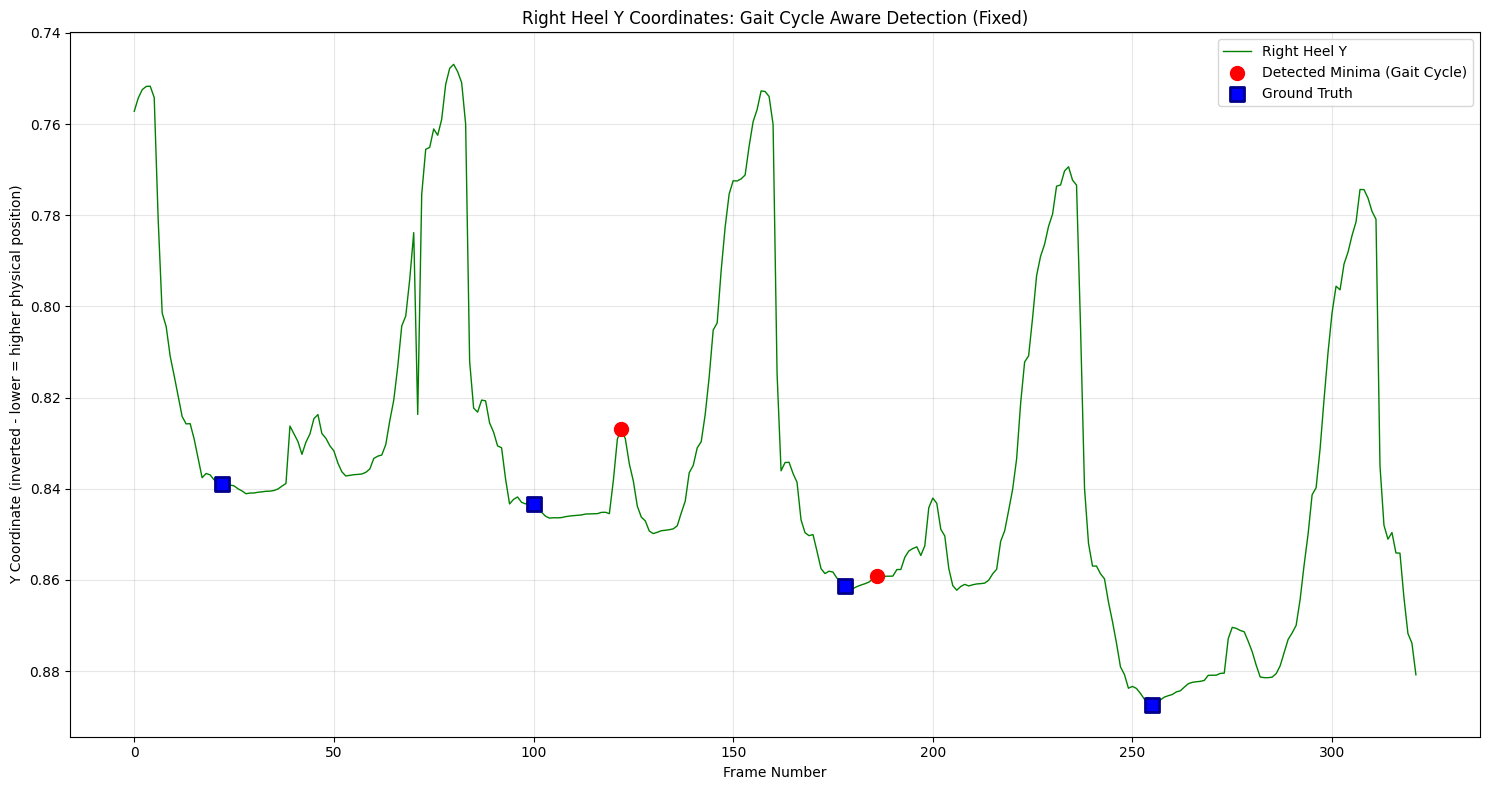


COMPARISON:
Ground truth right steps: 4
Detected minima: 2
Detection ratio: 0.50
DataFrame shape: (322, 12)
First few Y values: [0.7572038173675537, 0.7543185353279114, 0.7524665594100952, 0.751752495765686, 0.7517048120498657, 0.7541764974594116, 0.7810182571411133, 0.8014669418334961, 0.80443274974823, 0.8109229803085327]
Parameters: window_size=3, min_distance=10, jump_threshold_percentile=75


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where right heel is not usable (low confidence)
df_filtered = df[df['right_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable right heel frames: {len(df_filtered)}")

def find_local_minima_with_gait_cycle(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima with gait cycle awareness - only detect first minimum after swing phase
    (Adopted from successful left foot logic)
    """
    minima = []
    y_values = df_data['right_heel_y'].values
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    # First pass: find all potential minima and their Y-change magnitudes
    potential_minima = []
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Calculate directional Y-change around this minimum
            look_back = min(15, i)
            look_forward = min(15, n - i - 1)
            
            if look_back > 0 and look_forward > 0:
                before_y = np.mean(y_values[i-look_back:i])
                after_y = np.mean(y_values[i+1:i+look_forward+1])
                
                # Calculate directional changes
                drop_to_minimum = before_y - current_val  # Positive = dropped down to minimum
                rise_from_minimum = after_y - current_val  # Positive = rose up from minimum
                
                # For swing phases: big drop to minimum (high drop_to_minimum)
                # For heel strikes: big rise from minimum (high rise_from_minimum)
                swing_score = drop_to_minimum  # Higher = more likely swing phase
                heel_strike_score = rise_from_minimum  # Higher = more likely heel strike
                
                # Use swing_score as the classification metric (reversed as you requested)
                total_change = swing_score
                
                potential_minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val,
                    'y_change_magnitude': total_change,
                    'swing_score': swing_score,
                    'heel_strike_score': heel_strike_score
                })
    
    if not potential_minima:
        return []
    
    # Calculate threshold for Y-change magnitude
    y_changes = [m['y_change_magnitude'] for m in potential_minima]
    change_threshold = np.percentile(y_changes, jump_threshold_percentile)
    
    print(f"Y-change threshold (filtering top {100-jump_threshold_percentile}%): {change_threshold:.4f}")
    
    # Second pass: apply gait cycle logic
    last_swing_peak_frame = -1
    
    # Debug: Print all potential minima first
    print("\nDEBUG: All potential minima:")
    for minimum in potential_minima:
        print(f"Frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, Y-change={minimum['y_change_magnitude']:.4f}, Type={'SWING' if minimum['y_change_magnitude'] > change_threshold else 'HEEL'}")
    
    for minimum in potential_minima:
        if minimum['y_change_magnitude'] <= change_threshold:
            current_y = minimum['y_value']
            current_frame = minimum['frame_number']
            
            print(f"\nDEBUG: Processing heel strike candidate at frame {current_frame}, Y={current_y:.3f}")
            
            # Detect if we're transitioning from swing to stance
            swing_peaks_nearby = [m for m in potential_minima 
                                if m['y_change_magnitude'] > change_threshold 
                                and m['frame_number'] < current_frame 
                                and current_frame - m['frame_number'] < 60]  # Within last 60 frames
            
            print(f"  Found {len(swing_peaks_nearby)} swing peaks within 60 frames before")
            
            # Filter by Y-position (swing peak should be higher - lower Y value)
            swing_peaks_valid = [m for m in swing_peaks_nearby if m['y_value'] < current_y - 0.05]
            print(f"  {len(swing_peaks_valid)} swing peaks meet Y-position criteria (< {current_y - 0.05:.3f})")
            
            if swing_peaks_valid:
                # We found a swing peak before this minimum
                latest_swing = max(swing_peaks_valid, key=lambda x: x['frame_number'])
                print(f"  Latest valid swing peak: frame {latest_swing['frame_number']}, Y={latest_swing['y_value']:.3f}")
                
                # Only detect if this is the first minimum after a swing peak
                if latest_swing['frame_number'] > last_swing_peak_frame:
                    print(f"  This is first heel strike after swing at frame {latest_swing['frame_number']}")
                    # This is the first detection after a new swing phase
                    if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                        minima.append({
                            'index': minimum['index'],
                            'frame_number': minimum['frame_number'],
                            'timestamp': minimum['timestamp'],
                            'y_value': minimum['y_value']
                        })
                        last_swing_peak_frame = latest_swing['frame_number']
                        print(f"  ✅ ACCEPTED: Kept first minimum after swing at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}")
                    else:
                        print(f"  ❌ REJECTED: Filtered by distance: frame {minimum['frame_number']}")
                else:
                    print(f"  ❌ REJECTED: Already detected after this swing cycle (last_swing_peak_frame={last_swing_peak_frame})")
            else:
                if swing_peaks_nearby:
                    print(f"  ❌ REJECTED: Swing peaks found but none meet Y-position criteria")
                    for sp in swing_peaks_nearby:
                        print(f"    Swing at frame {sp['frame_number']}: Y={sp['y_value']:.3f} (need < {current_y - y_position_threshold:.3f})")
                else:
                    print(f"  ❌ REJECTED: No preceding swing phase found")
        else:
            print(f"\nSwing phase peak detected at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, Swing score={minimum['swing_score']:.4f}")
    
    return minima

# Find local minima using gait cycle approach
minima = find_local_minima_with_gait_cycle(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth RIGHT foot steps  
gt_right_steps = [step for step in gt_data['annotations'] if step['foot'] == 'right']
print(f"\nGround truth right foot steps: {len(gt_right_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_right_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['right_heel_y'].iloc[0])
        print(f"GT: Frame {frame_num}, Time {gt_step['timestamp']:.3f}s, Y = {matching_row['right_heel_y'].iloc[0]:.5f}")

# Calculate intervals between steps
if len(minima) > 1:
    intervals = []
    for i in range(1, len(minima)):
        interval = minima[i]['timestamp'] - minima[i-1]['timestamp']
        intervals.append(interval)
    
    print(f"\nDetected step intervals:")
    for i, interval in enumerate(intervals):
        print(f"  Interval {i+1}: {interval:.3f}s")
    
    print(f"\nTiming statistics:")
    print(f"  Average interval: {np.mean(intervals):.3f}s")
    print(f"  Std deviation: {np.std(intervals):.3f}s")

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['right_heel_y'], 'g-', linewidth=1, label='Right Heel Y')

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='Detected Minima (Gait Cycle)')

# Mark ground truth (BLUE squares)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=100, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate (inverted - lower = higher physical position)')
plt.title('Right Heel Y Coordinates: Gait Cycle Aware Detection (Fixed)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Compare detection accuracy
print(f"\n{'='*50}")
print("COMPARISON:")
print(f"Ground truth right steps: {len(gt_right_steps)}")
print(f"Detected minima: {len(minima)}")
print(f"Detection ratio: {len(minima)/len(gt_right_steps):.2f}" if gt_right_steps else "N/A")

